In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import sys
sys.path.append('GAN')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
import numpy as np

In [3]:
from tensorflow.keras.datasets import mnist
# load data
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
# utility function
import scipy
import moviepy.editor as mpy
def visualize_imgs(imgs, shape, save_path=None):
    (row, col) = shape[0], shape[1]
    height, width = imgs[0].shape[:2]
    total_img = np.zeros((height*row, width*col))
    for n, img in enumerate(imgs):
        j = int(n/col)
        i = n%col
        total_img[j*height:(j+1)*height,i*width:(i+1)*width] = img
    if save_path is not None:
        scipy.misc.imsave(save_path, img)
    return total_img
  
def make_gif(images, fname, duration=2, true_image=False):    
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x+1)/2*255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
def iter_data(*data, **kwargs):
    size = kwargs.get('batch_size', 128)
    try:
        n = len(data[0])
    except:
        n = data[0].shape[0]
    batches = int(n / size)
    if n % size != 0:
        batches += 1
    for b in range(batches):
        start = b * size
        end = (b + 1) * size
        if end > n:
            end = n
        if len(data) == 1:
            yield data[0][start:end]
        else:
            yield tuple([d[start:end] for d in data])

In [5]:
class DCGAN(object):
    def __init__(self, image_size, image_channel, z_dim=128, learning_rate=1e-4):
        self.image_size = image_size
        self.image_channel = image_channel
        self.z_dim = z_dim
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size,
                                              self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)

        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_real,
                                          labels=tf.ones_like(self.logit_real)))
        self.d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake,
                                          labels=tf.zeros_like(self.logit_fake)))
        self.d_loss = self.d_loss_real + self.d_loss_fake

        # loss of generator
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake,
                                          labels=tf.ones_like(self.logit_fake)))
       
        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.d_loss,
                                                                            var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.g_loss,
                                                                             var_list=self.g_vars)

    def discriminator(self, image):
        lrelu = tf.nn.leaky_relu
        conv2d = tf.layers.conv2d
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense    
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
            if self.image_channel==1:
                image = tf.reshape(image, [-1, self.image_size, self.image_size, 1])
            hidden = self.z
            hidden = image
            hidden = lrelu(conv2d(hidden, 32, kernel_size=5, strides=2, padding='same'))
            hidden = lrelu(bn(conv2d(hidden, 128, kernel_size=5, strides=2, padding='same'),
                              training=True))
            hidden = tf.layers.flatten(hidden)
            hidden = lrelu(bn(linear(hidden, 1024), training=True))
            hidden = linear(hidden, 1)
            return tf.nn.sigmoid(hidden), hidden

    def generator(self, y=None):
        relu = tf.nn.relu
        deconv2d = tf.layers.conv2d_transpose
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope("generator"):
            self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
            hidden = self.z
            hidden = relu(bn(linear(hidden, 1024), training=True))
            hidden = relu(bn(linear(hidden, (self.image_size//4)*(self.image_size//4)*128),
                             training=True))
            hidden = tf.reshape(hidden, [-1, self.image_size//4, self.image_size//4, 128])
            hidden = relu(bn(deconv2d(hidden, 32, kernel_size=5, strides=2, padding='same'),
                             training=True))
            hidden = tf.nn.sigmoid(deconv2d(hidden, self.image_channel, kernel_size=5,
                                            strides=2, padding='same'))
            if self.image_channel==1:
                hidden = tf.reshape(hidden, [-1, self.image_size, self.image_size])
            return hidden
          
    def train(self, sess, x_train, num_epoch=100, batch_size=100, num_sample=100,
              show_samples=True, sample_path='./samples', n_critic=2, log=False):
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                batch_z = np.random.uniform(-1, 1,
                                            [batch_size, self.z_dim]).astype(np.float32)
                if counter % (n_critic+1) != 0:
                    # Update D network
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op],
                                         feed_dict=feed_dict)
                    d_losses.append(d_loss)
                else:
                    # Update G network
                    g_loss, _ = sess.run([self.g_loss, self.g_update_op],
                                         feed_dict={self.z: batch_z})
                    g_losses.append(g_loss)
                counter += 1
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20),
                                 save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
                
            if (epoch+1) % 10 == 0:
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch
      
    def save_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=step)
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))
        
    def load_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name+'-{}'.format(step)))
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))

In [6]:
#Inherit from DCGAN class
class WGAN(DCGAN):
    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32,
                                             [None, self.image_size,
                                              self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)
        
        # gradient penalty
        epsilon = tf.random_uniform([100, 28, 28], 0.0, 1.0)
        x_hat = epsilon * self.image_fake + (1-epsilon) * self.image_real
        d_hat, _ = self.discriminator(x_hat)
        d_hat = tf.gradients(d_hat, x_hat)[0]
        d_hat = tf.sqrt(tf.reduce_sum(tf.square(d_hat), axis=1))
        d_hat = tf.reduce_mean(0.1 * tf.square(d_hat - 1.0))

        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(self.logit_real)
        self.d_loss_fake = tf.reduce_mean(self.logit_fake)                        
        self.d_loss = self.d_loss_fake - self.d_loss_real + d_hat

        # loss of generator
        self.g_loss = -tf.reduce_mean(self.logit_fake)
       
        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.d_loss, var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.g_loss, var_list=self.g_vars)
        
        # create weight cliping operation
        self.weight_clip_ops = []
        for var in self.d_vars:            
            self.weight_clip_ops.append(var.assign(tf.clip_by_value(var, -0.01, 0.01)))
            
    def train(self, sess, x_train, num_epoch=100, batch_size=100, 
              num_sample=100, show_samples=True, n_critic=2, 
              sample_path='./samples', log=False): 
    
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()        
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                batch_z = np.random.uniform(-1, 1, [batch_size, self.z_dim]).astype(np.float32)
                if counter % (n_critic+1) != 0:
                    # Update D network
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op],
                                         feed_dict=feed_dict)
                    d_losses.append(d_loss)
                    sess.run(self.weight_clip_ops)
                else:
                    # Update G network
                    g_loss, _ = sess.run([self.g_loss, self.g_update_op],
                                         feed_dict={self.z: batch_z})
                    g_losses.append(g_loss)
                counter += 1                                        
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20),
                                 save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
                
            if (epoch+1) % 10 == 0:
                self.save_model(sess, step=counter)
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch

In [7]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
wgan = WGAN(image_size=28, image_channel=1, learning_rate=5e-5)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

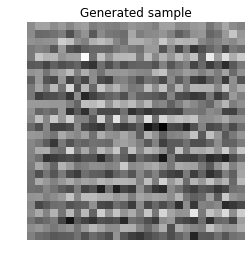

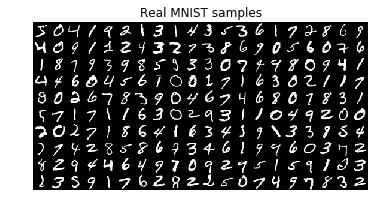

In [8]:
sample_z = np.random.uniform(-1, 1, size=(200 , wgan.z_dim))
samples = sess.run(wgan.image_fake, feed_dict = {wgan.z: sample_z})

plt.imshow(samples[0].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = x_train[:200]
img = visualize_imgs(samples, shape=(10,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

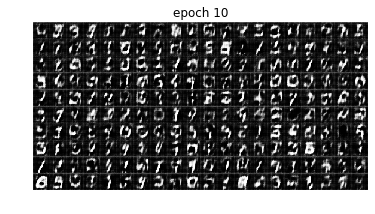

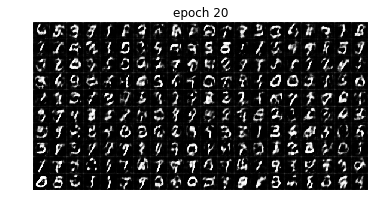

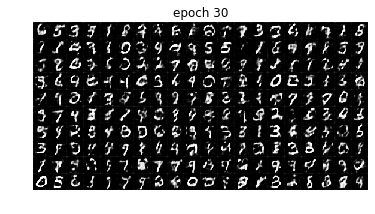

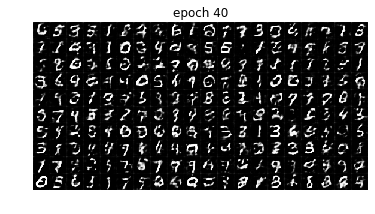

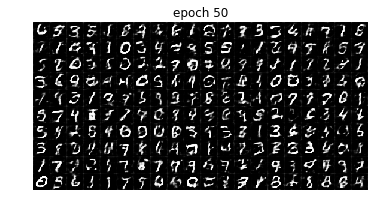

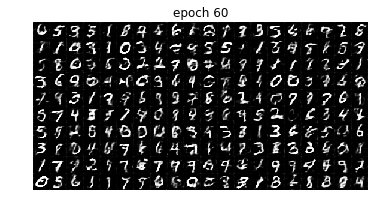

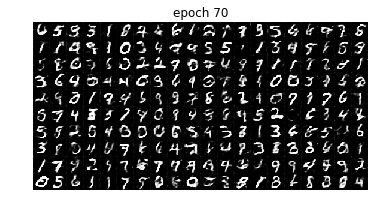

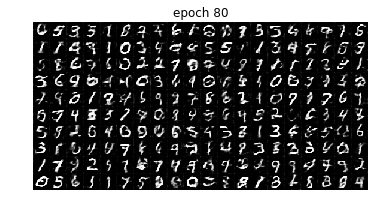

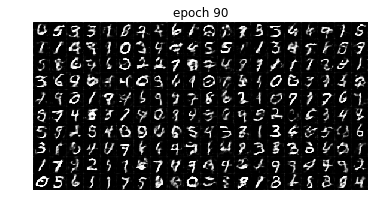

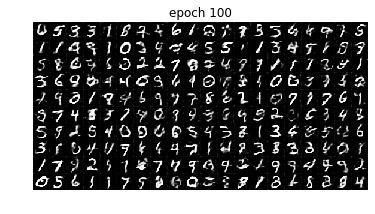

In [9]:
# Start training
sample_imgs, d_loss_epoch, g_loss_epoch = wgan.train(sess, x_train, num_sample=200, num_epoch=100, n_critic=5)

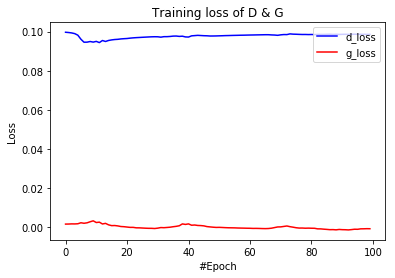

In [10]:
plt.plot(range(len(d_loss_epoch)), d_loss_epoch, color = 'blue', label = 'd_loss')
plt.plot(range(len(g_loss_epoch)), g_loss_epoch, color = 'red', label = 'g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [11]:
imgs = np.array(sample_imgs)
make_gif(imgs*255., 'wgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='wgan.gif')   


[MoviePy] Building file wgan.gif with imageio


 99%|█████████▉| 100/101 [00:02<00:00, 46.52it/s]


# WGAN 相較於 GAN 做的改進：
1. discriminator 去掉 sigmoid
2. generator 和 discriminator 的 loss 不取 log
3. update 過後的 weight 做 clipping (ex -0.01~0.01)
4. 用 RMSprop

# Improved WGAN 將較於 WGAN 做的改進：
1. 使用 gradient penalty

# 嘗試過的參數

根據助教給的演算法 pseudo code 我將 gradient penalty coefficient 設為 10，beta1 設為 0， beta2 設為 0.9。但是不知道為什麼這樣的參數完全 train 不起來。最後將 10 改為 0，beta 則全部使用預設值就成功了。 

# 應用

https://medium.com/@jonathan_hui/gan-some-cool-applications-of-gans-4c9ecca35900 <br>
這個網站整理了很多 GAN 在生活中的真實應用
1. 利用各種姿勢的照片作為 input，就可以幫同一個模特兒產生各種不同的拍照姿勢
2. 照片風格轉移 (寫實 -> 印象)
3. 聊天機器人
4. 從一個名人的穿搭照片中提取重點，產生衣服或配件的圖片。

https://www.zhihu.com/question/52602529 <br>
這個網站中有舉出更多在影像處理方面的應用，例如從衛星影像得到地圖、黑白照片變成彩色照片、將照片做春夏秋冬的季節轉換 <br>

https://github.com/nashory/gans-awesome-applications <br>
這裡有很多的實際應用